# Laporan Proyek Machine Learning - Prediksi Harga Saham Berbasis Menggunakan LSTM

Wisnu Al Hussaeni - MC001D5Y1239

## Domain Proyek
Harga saham merupakan indikator penting dalam pasar keuangan yang mencerminkan performa perusahaan dan dinamika pasar. PT GoTo Gojek Tokopedia (GOTO), sebuah perusahaan teknologi terkemuka di Indonesia. Data historis saham GOTO dapat diakses melalui [investing.com](https://id.investing.com/equities/goto-gojek-tokopedia-pt-historical-data). Prediksi harga saham yang akurat sangat penting bagi investor, trader, dan institusi keuangan untuk mendukung pengambilan keputusan investasi, manajemen risiko, dan strategi perdagangan. Pendekatan tradisional seperti analisis teknikal dan fundamental sering kali tidak mampu menangkap pola kompleks dan non-linear dalam data harga saham, yang dipengaruhi oleh faktor seperti sentimen pasar, kebijakan ekonomi, dan peristiwa global. Oleh karena itu, pendekatan berbasis *machine learning*, khususnya **Long Short-Term Memory (LSTM)**, menjadi relevan karena kemampuannya dalam menangani data deret waktu dengan ketergantungan jangka panjang. Proyek ini bertujuan untuk membangun model prediktif menggunakan LSTM untuk memprediksi harga penutupan saham **GOTO** berdasarkan data historis dari investing.com, dengan memanfaatkan kemampuan LSTM untuk menangkap pola temporal, proyek ini diharapkan dapat memberikan wawasan prediktif yang mendukung investor dalam membuat keputusan yang lebih tepat waktu dan *informed*, baik untuk strategi jangka pendek maupun menengah.

### Mengapa Masalah Ini Penting?
1. Volatilitas tinggi : Saham seperti GOTO sering mengalami fluktuasi harga yang signifikan dalam periode singkat.
2. Keputusan investasi : Prediksi yang baik dapat membantu investor membuat strategi masuk/keluar pasar.
3. Pemanfaatan AI dalam keuangan : Teknik machine learning semakin relevan untuk analisis pasar modal modern.

## Business Understanding
### Problem Statement
1. Seberapa akurat model LSTM dalam memprediksi harga penutupan saham **GOTO** untuk 1 hari dan 5 hari ke depan berdasarkan data historis?
2.  Bagaimana performa model LSTM dibandingkan dengan metrik evaluasi seperti **Root Mean Squared Error (RMSE)** dan **Mean Absolute Error (MAE)**?
3. Apakah model LSTM dapat digunakan untuk mendukung keputusan investasi jangka pendek atau menengah?

### Goals
Berdasarkan *problem statements*, tujuan proyek ini adalah:
1. Membangun model LSTM yang akurat untuk memprediksi harga penutupan saham **GOTO**.
2. Mengevaluasi performa model menggunakan metrik **RMSE** dan **MAE**.
3. Menyediakan wawasan prediktif yang dapat mendukung keputusan investasi.

### Solution Statement
1. Melakukan **Exploratory Data Analysis (EDA)** untuk mengidentifikasi pola, tren, dan korelasi dalam data harga saham **GOTO**.
2. Menggunakan model **LSTM** untuk memprediksi harga penutupan saham berdasarkan data historis.
3. Menggunakan metrik evaluasi seperti **RMSE** dan **MAE** untuk menilai performa model.
4. Melakukan normalisasi data menggunakan **StandardScaler** untuk memastikan data sesuai dengan kebutuhan model LSTM.
5. Mengoptimalkan model dengan **EarlyStopping** dan **ReduceLROnPlateau** untuk meningkatkan akurasi prediksi.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
file_path = '/content/Data Historis Gojek Tokopedia PT (GOTO).csv'
df = pd.read_csv(file_path, sep=';')
df.head()

,"Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%"
0,"2/12/2020,""11,820"",""12,480"",""12,480"",""11,820"",..."
1,"3/12/2020,""11,900"",""11,820"",""11,900"",""11,800"",..."
2,"4/12/2020,""12,400"",""12,990"",""13,980"",""11,500"",..."
3,"7/12/2020,""12,550"",""13,150"",""14,000"",""12,200"",..."
4,"8/12/2020,""12,377"",""12,990"",""13,440"",""12,250"",..."


## Data Preparation

1. Merapihkan kolom
2. Konversi 'Tangga' ke datetime
3. Membersihkan kolom yang masih mengandung , atau "
4. Mengkonversi kolom vol ke numerik

In [4]:
df.columns

Index(['Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%'], dtype='object')

In [5]:
# merapihkan kolom
data = df['Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%'].str.split(r',(?=(?:[^"]*"[^"]*")*[^"]*$)', expand=True)
data = data.iloc[:, :7]
data.columns = ['Tanggal', 'Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah', 'Vol.', 'Perubahan%']
df = df.drop('Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%', axis=1)
df = pd.concat([df, data], axis=1)
display(df.head())

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2/12/2020,"""11,820""","""12,480""","""12,480""","""11,820""","""1,00K""","""-0,59%"""
1,3/12/2020,"""11,900""","""11,820""","""11,900""","""11,800""","""14,14K""","""0,68%"""
2,4/12/2020,"""12,400""","""12,990""","""13,980""","""11,500""","""15,53K""","""4,20%"""
3,7/12/2020,"""12,550""","""13,150""","""14,000""","""12,200""","""14,52K""","""1,21%"""
4,8/12/2020,"""12,377""","""12,990""","""13,440""","""12,250""","""14,94K""","""-1,38%"""


In [6]:
# Konversi kolom 'Tanggal' ke datetime
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')

# Bersihkan dan konversi kolom numerik (Terakhir, Pembukaan, Tertinggi, Terendah)
for col in ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah']:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False)
    df[col] = df[col].astype(str).str.replace('"', '', regex=False)
    df[col] = pd.to_numeric(df[col])

In [7]:
# Konversi kolom Vol. ke numerik
def convert_volume(vol):
    vol = vol.replace('"', '')
    vol = vol.replace(',', '.')
    if 'K' in vol:
        return float(vol.replace('K', '')) * 1000
    elif 'M' in vol:
        return float(vol.replace('M', '')) * 1000000
    else:
        return float(vol)

df['Vol.'] = df['Vol.'].apply(convert_volume)

# Konversi kolom Perubahan% ke numerik
df['Perubahan%'] = df['Perubahan%'].str.replace(',', '.').str.replace('%', '').str.replace('"', '').astype(float)

## Data Understanding

In [8]:
display(df.head())

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2020-12-02,11820,12480,12480,11820,1000.0,-0.59
1,2020-12-03,11900,11820,11900,11800,14140.0,0.68
2,2020-12-04,12400,12990,13980,11500,15530.0,4.20
3,2020-12-07,12550,13150,14000,12200,14520.0,1.21
4,2020-12-08,12377,12990,13440,12250,14940.0,-1.38


### Variabel pada Dataset
- **Tanggal**: Tanggal perdagangan (format: DD/MM/YYYY).
- **Terakhir**: Harga penutupan saham pada hari tersebut.
- **Pembukaan**: Harga pembukaan saham pada hari tersebut.
- **Tertinggi**: Harga tertinggi saham pada hari tersebut.
- **Terendah**: Harga terendah saham pada hari tersebut.
- **Vol.**: Volume perdagangan saham (dalam ribuan).
- **Perubahan%**: Persentase perubahan harga penutupan dibandingkan hari sebelumnya.

In [9]:
df.shape

(1124, 7)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124 entries, 0 to 1123
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Tanggal     1124 non-null   datetime64[ns]
 1   Terakhir    1124 non-null   int64         
 2   Pembukaan   1124 non-null   int64         
 3   Tertinggi   1124 non-null   int64         
 4   Terendah    1124 non-null   int64         
 5   Vol.        1124 non-null   float64       
 6   Perubahan%  1124 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 61.6 KB


In [11]:
df.isnull().sum()

,0
Tanggal,0
Terakhir,0
Pembukaan,0
Tertinggi,0
Terendah,0
Vol.,0
Perubahan%,0


In [12]:
df.duplicated().sum()

np.int64(0)

In [13]:
df.describe()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
count,1124,1124.000000,1124.000000,1124.000000,1124.000000,1.124000e+03,1124.000000
mean,2023-02-26 08:45:16.014234880,5609.766014,5634.719751,5779.925267,5470.687722,1.873208e+07,0.006068
min,2020-12-02 00:00:00,2310.000000,2330.000000,2330.000000,2190.000000,1.000000e+03,-37.280000
25%,2022-01-12 18:00:00,3190.000000,3190.000000,3260.000000,3124.000000,8.792500e+06,-1.670000
50%,2023-02-27 12:00:00,3610.000000,3620.000000,3690.000000,3545.000000,1.590000e+07,0.000000
75%,2024-04-10 06:00:00,6275.000000,6322.500000,6602.500000,5950.000000,2.494500e+07,1.602500
max,2025-05-23 00:00:00,17060.000000,17260.000000,18109.000000,15550.000000,1.787800e+08,27.240000
std,NaN,3722.399519,3763.004711,3883.084381,3616.770376,1.782305e+07,4.072438


tidak adanya missing value maupun duplikasi pada dataset yang digunakan

### Exploratory Data Analysis (EDA)

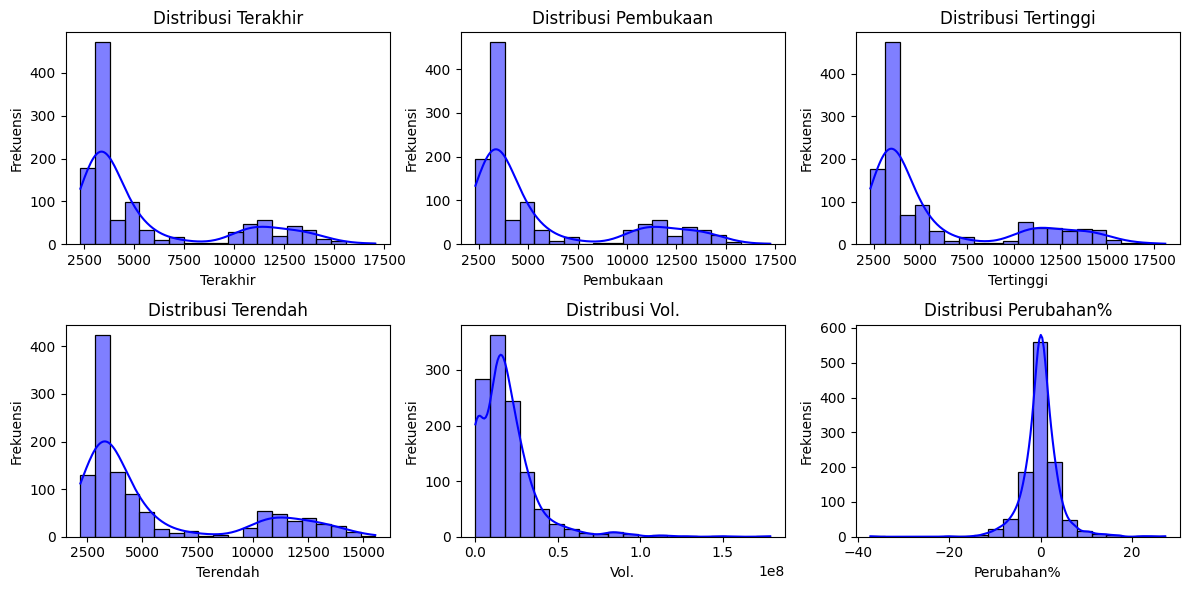

In [14]:
# distribusi tiap kolom
feature = ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah', 'Vol.', 'Perubahan%']
plt.figure(figsize=(12, 6))
for i, col in enumerate(feature, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=20, color='blue', edgecolor='black', kde=True)
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

# Insight Distribusi Data
## 1. Harga (Terakhir, Pembukaan, Tertinggi, Terendah)
- **Modus**: Sekitar `2500–3000`
- **Bentuk distribusi**: *Right-skewed*
- **Insight**:
  - Mayoritas harga berada di kisaran rendah.
  - Terdapat beberapa outlier dengan nilai sangat tinggi.
  - Menunjukkan stabilitas dengan sesekali fluktuasi ekstrem.

## 2. Volume Transaksi ("Vol.")
- **Modus**: Sekitar `0.0–0.1`
- **Bentuk distribusi**: *Left-skewed*
- **Insight**:
  - Sebagian besar volume transaksi kecil.
  - Ada beberapa kasus dengan volume sangat besar (outlier).

## 3. Perubahan Persentase ("Perubahan%")
- **Bentuk distribusi**: Simetris / mendekati normal
- **Pusat distribusi**: Di sekitar `0%`
- **Insight**:
  - Pergerakan harga cenderung stabil.
  - Variasi naik dan turun seimbang.

## Kesimpulan Umum
- Harga berkumpul di kisaran `2500–3000` dengan sedikit lonjakan ekstrem.
- Volume transaksi umumnya rendah, tetapi bisa menjadi sangat tinggi.
- Perubahan harga relatif stabil dan seimbang antara positif dan negatif.

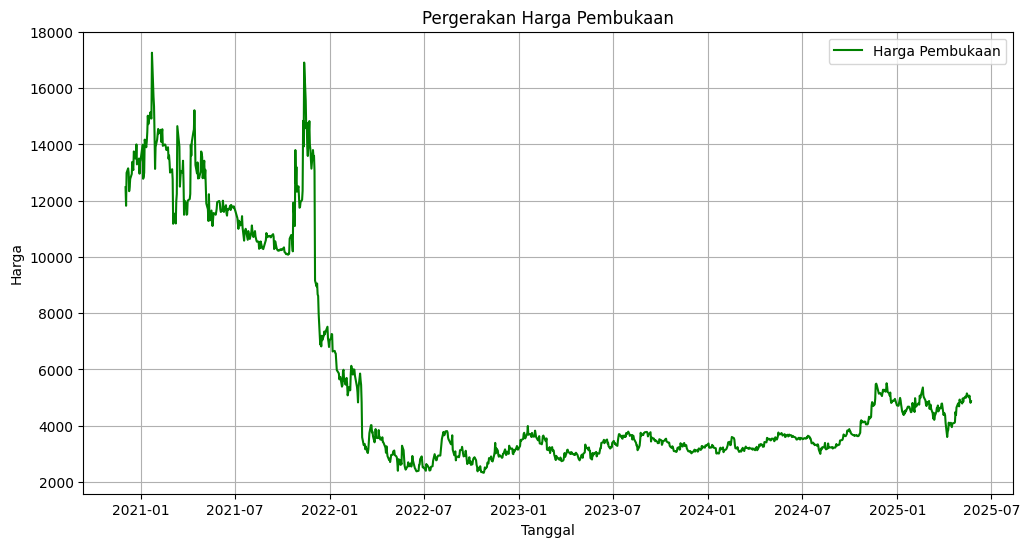

In [15]:
# plot harga pembukaan
plt.figure(figsize=(12, 6))
plt.plot(df['Tanggal'], df['Pembukaan'], label='Harga Pembukaan', color='green')
plt.title('Pergerakan Harga Pembukaan')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()

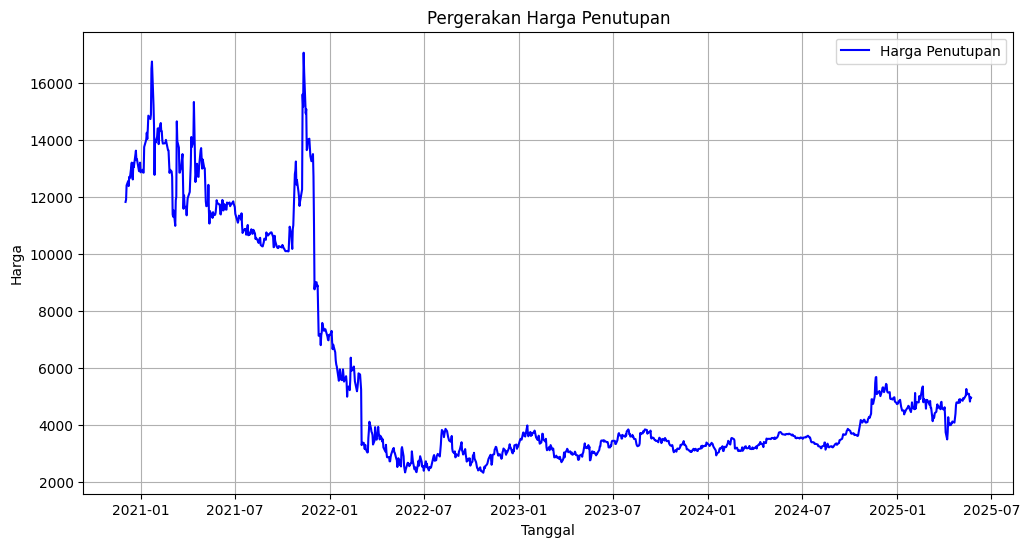

In [16]:
# plot harga penutupan
plt.figure(figsize=(12, 6))
plt.plot(df['Tanggal'], df['Terakhir'], label='Harga Penutupan', color='blue')
plt.title('Pergerakan Harga Penutupan')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()

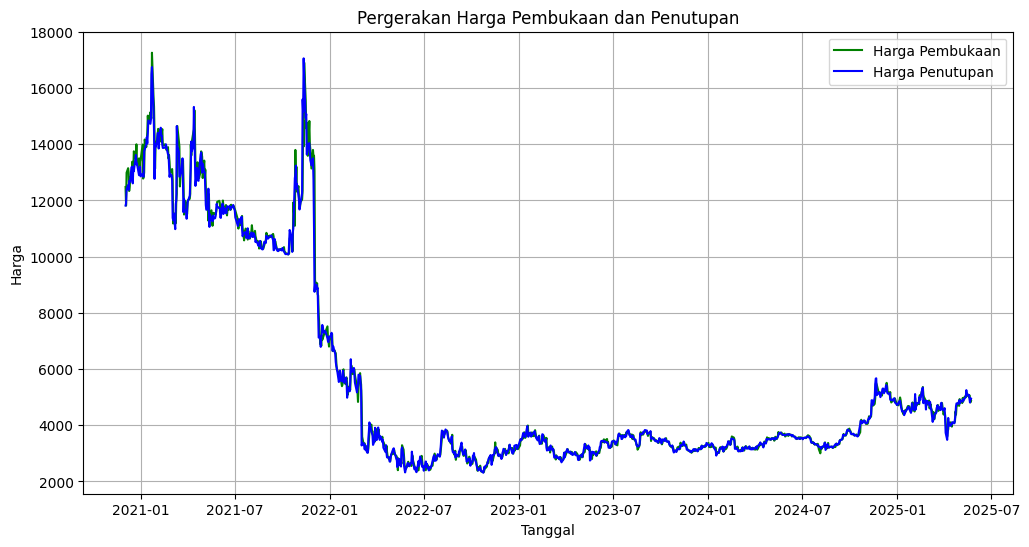

In [17]:
# plot pembukaan dan penutupan
plt.figure(figsize=(12, 6))
plt.plot(df['Tanggal'], df['Pembukaan'], label='Harga Pembukaan', color='green')
plt.plot(df['Tanggal'], df['Terakhir'], label='Harga Penutupan', color='blue')
plt.title('Pergerakan Harga Pembukaan dan Penutupan')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()

### Pembukaan dan Penutupan
- **Stabilitas Awal (2021)**: Harga stabil di kisaran tinggi.
- **Krisis 2022**: Penurunan drastis, menandakan dampak besar dari faktor eksternal.
- **Pemulihan Lambat (2023–2025)**: Harga pulih secara bertahap, tetapi belum mencapai level sebelum krisis.
- **Insight**: Aset ini memiliki volatilitas tinggi, memerlukan strategi investasi yang hati-hati.

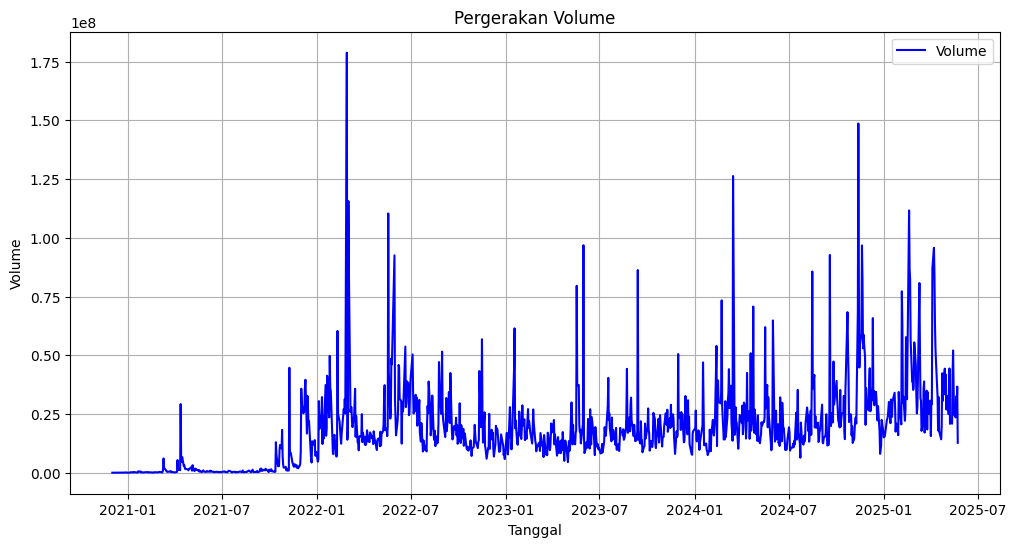

In [18]:
# plot vol.
plt.figure(figsize=(12, 6))
plt.plot(df['Tanggal'], df['Vol.'], label='Volume', color='blue')
plt.title('Pergerakan Volume')
plt.xlabel('Tanggal')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

### Vol
- **Aktivitas Tinggi (Awal 2022)**: Volume mencapai puncak tertinggi.
- **Penurunan Aktivitas (2022–2023)**: Volume turun drastis dan stabil di kisaran rendah.
- **Pemulihan Aktivitas (2024–2025)**: Volume meningkat kembali, meskipun belum mencapai level tertinggi.
- **Insight**: Volume transaksi berkorelasi dengan aktivitas pasar dan volatilitas harga.

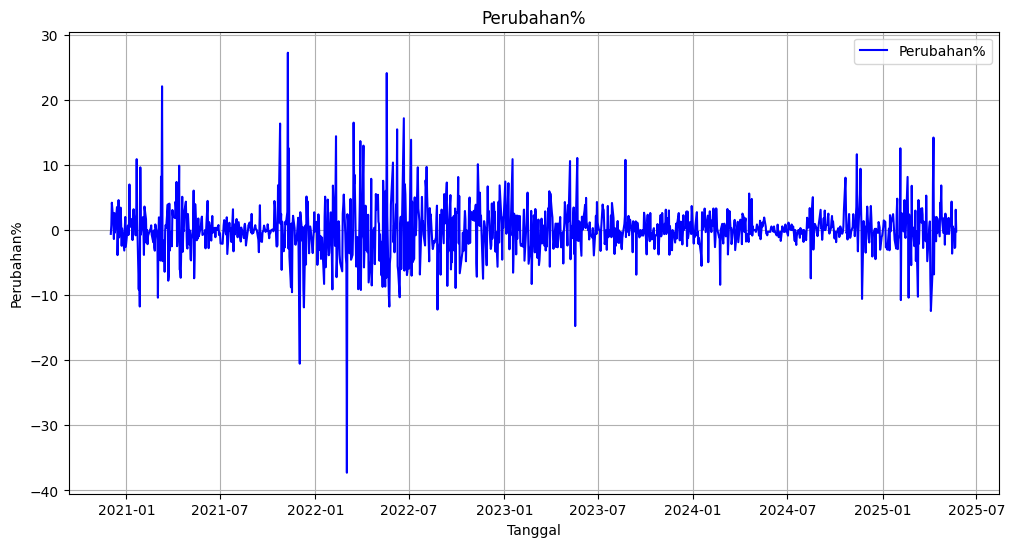

In [19]:
# plot perubahan%
plt.figure(figsize=(12, 6))
plt.plot(df['Tanggal'], df['Perubahan%'], label='Perubahan%', color='blue')
plt.title('Perubahan%')
plt.xlabel('Tanggal')
plt.ylabel('Perubahan%')
plt.legend()
plt.grid(True)
plt.show()

### Perubahan
- **Stabilitas Awal (2021)**: Persentase perubahan stabil di kisaran positif.
- **Krisis 2022**: Penurunan drastis hingga **-40%**, menandakan dampak besar dari faktor eksternal.
- **Pemulihan Lambat (2022–2025)**: Persentase perubahan pulih secara bertahap, meskipun belum mencapai level tertinggi.
- **Insight**: Aset ini memiliki volatilitas tinggi, memerlukan strategi investasi yang hati-hati.

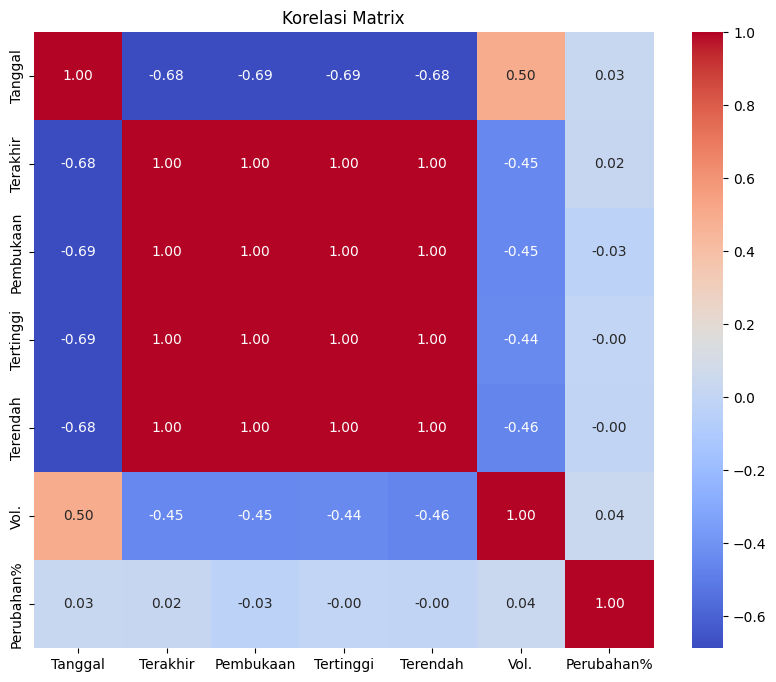

In [20]:
# corelasi matrix
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi Matrix')
plt.show()


- **Hubungan Waktu dan Harga**: Ada hubungan negatif kuat antara waktu dan harga.
- **Volume Transaksi**: Memiliki hubungan negatif menengah dengan harga.
- **Perubahan Persentase**: Hubungan rendah dengan variabel lainnya.
- **Model Prediksi**: Fokus pada variabel yang memiliki korelasi tinggi dengan target prediksi.

# Data Preparation Sebelum Modeling

In [21]:
# drop kolom perubahan
df_baru = df.copy()
df_baru = df_baru.drop('Perubahan%', axis=1)

In [22]:
df_baru.head()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.
0,2020-12-02,11820,12480,12480,11820,1000.0
1,2020-12-03,11900,11820,11900,11800,14140.0
2,2020-12-04,12400,12990,13980,11500,15530.0
3,2020-12-07,12550,13150,14000,12200,14520.0
4,2020-12-08,12377,12990,13440,12250,14940.0


In [23]:
# normalisasi data
scaler = StandardScaler()
df_baru['Terakhir'] = scaler.fit_transform(df_baru[['Terakhir']])

Kolom Terakhir dinormalisasi menggunakan StandardScaler agar data memiliki rata-rata 0 dan standar deviasi 1. Ini membantu model LSTM belajar lebih baik.

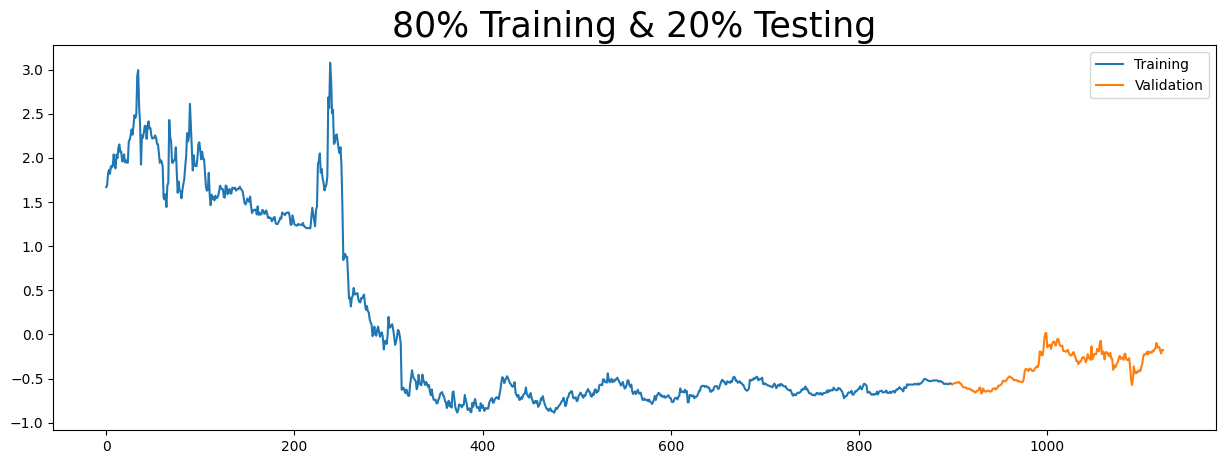

In [24]:
# Fungsi untuk membagi data menjadi train dan test
def split_data(df, train_size):
  size = int(len(df) * train_size)
  train, test = df.iloc[0:size], df.iloc[size:len(df)]
  return train, test

# Bagi data 'close' menjadi 80% train dan 20% test
train, test = split_data(df_baru['Terakhir'], 0.8)

# Visualisasi pembagian data
plt.figure(figsize=(15,5))
plt.plot(train, label='Training')
plt.plot(test, label='Validation')
plt.title('80% Training & 20% Testing', fontsize=25)
plt.legend()
plt.show()

Data Terakhir dibagi menjadi:
- 80% data latih (training): untuk melatih model.
- 20% data uji (testing): untuk menguji performa model.

In [25]:
# look_back: jumlah hari sebelumnya yang digunakan untuk memprediksi hari berikutnya
def split_target(df, look_back=1):
    X, y = [], []
    for i in range(len(df) - look_back):
        a = df[i:(i + look_back), 0]
        X.append(a)
        y.append(df[i + look_back, 0])
    return np.array(X), np.array(y)

# train.values.reshape(-1, 1) mengubah data training menjadi numpy array 2D
X_train, y_train = split_target(train.values.reshape(-1, 1))
X_test, y_test = split_target(test.values.reshape(-1, 1))

# Fitur adalah look_back, yang merupakan jumlah hari sebelumnya
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Fungsi split_target membuat urutan data:
- Model memakai harga hari sebelumnya (look_back=1) untuk memprediksi harga hari berikutnya.
- Data diubah menjadi format 3D [jumlah data, langkah waktu, fitur] agar sesuai dengan kebutuhan LSTM.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 1.0627 - val_loss: 0.1574 - learning_rate: 0.0010
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5199 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0520 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0265 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0282 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0266 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0244 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0207 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0226 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 10/50
29/29 ━━━━━━━━━

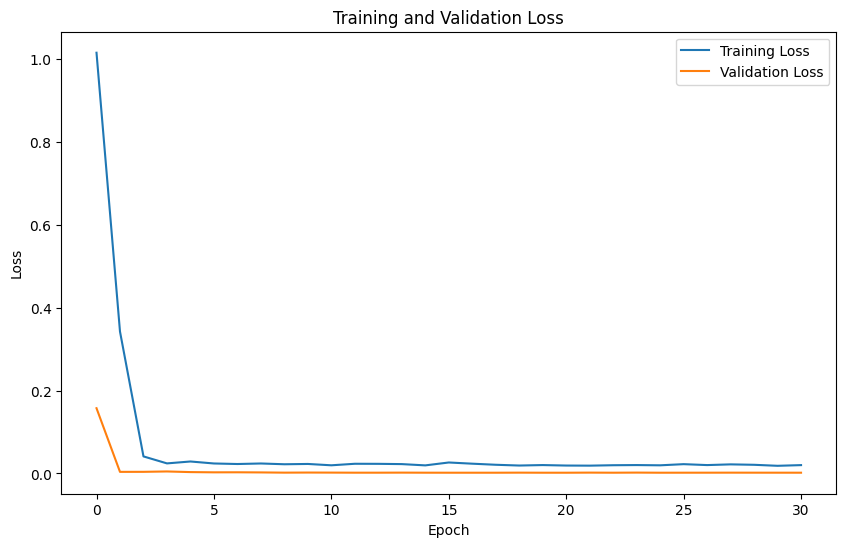

In [26]:
# Building the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Model LSTM yang digunakan terdiri dari:
- 2 lapisan LSTM (masing-masing 50 unit).
- Lapisan Dropout (20%) untuk mencegah overfitting.
- 2 lapisan Dense (25 unit, lalu 1 unit untuk output harga).
- Model dilatih menggunakan optimizer Adam dan fungsi kerugian Mean Squared Error (MSE).

Model dilatih selama maksimal 50 epoch dengan batch size 32.
Ada 2 fitur tambahan:
- EarlyStopping: menghentikan pelatihan jika error pada data uji tidak membaik setelah 10 epoch.
- ReduceLROnPlateau: mengurangi learning rate jika error tidak membaik.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
RMSE: 150.17735956242205
MAE: 95.20398494175502


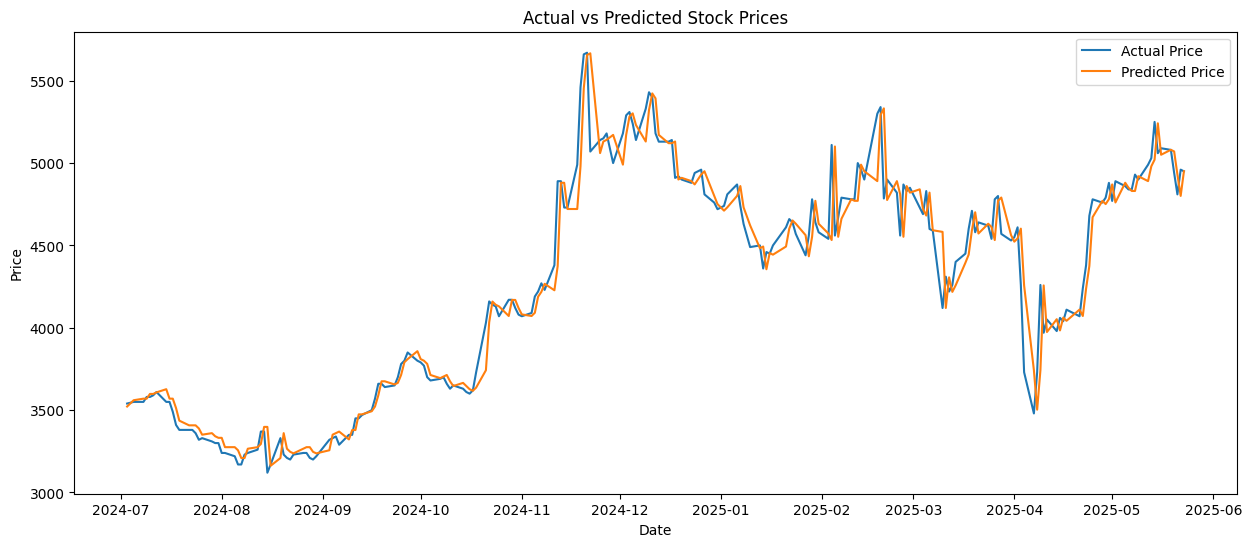

In [27]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mae = mean_absolute_error(y_test_actual, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Plot actual vs predicted prices
plt.figure(figsize=(15, 6))
plt.plot(df_baru['Tanggal'].iloc[-len(y_test_actual):], y_test_actual, label='Actual Price')
plt.plot(df_baru['Tanggal'].iloc[-len(predictions):], predictions, label='Predicted Price')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Setelah dilatih, model membuat prediksi pada data uji, lalu hasilnya dikembalikan ke skala asli menggunakan scaler.inverse_transform.
Hasil evaluasi:
- RMSE (Root Mean Squared Error): 150.18 → rata-rata error prediksi sekitar 150 unit dalam skala harga asli.
- MAE (Mean Absolute Error): 95.20 → rata-rata selisih absolut antara harga asli dan prediksi adalah 95 unit.

Grafik menunjukkan perbandingan harga saham asli (biru) dan prediksi (jingga) dari Juli 2024 hingga Juni 2025:
- Prediksi mengikuti tren harga asli dengan cukup baik.
- Secara keseluruhan, prediksi cukup dekat dengan harga asli, sesuai dengan nilai RMSE dan MAE.

## Data Preparation
### Membuat urutan input-output 30 hari

- Membuat urutan input-output (30 hari untuk memprediksi 5 hari berikutnya)
- create_sequences: Fungsi untuk membuat urutan data input (X) dan output (y)
- seq_length: panjang urutan input (berapa hari data sebelumnya yang digunakan)
- pred_length: panjang urutan prediksi (berapa hari ke depan yang akan diprediksi)

In [28]:
def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[(i + seq_length):(i + seq_length + pred_length), 0])
    return np.array(X), np.array(y)

sequence_length = 30  # Gunakan data 30 hari sebelumnya
prediction_length = 5  # Prediksi 5 hari ke depan

# train.values.reshape(-1, 1) mengubah data training menjadi array numpy 2D dengan satu kolom
X_train, y_train = create_sequences(train.values.reshape(-1, 1), sequence_length, prediction_length)
X_test, y_test = create_sequences(test.values.reshape(-1, 1), sequence_length, prediction_length)

# Time steps adalah sequence_length (60), dan fitur adalah 1 (untuk harga 'Terakhir')
X_train = X_train.reshape((X_train.shape[0], sequence_length, 1))
X_test = X_test.reshape((X_test.shape[0], sequence_length, 1))

# Mengubah bentuk data output (y) menjadi 2D (sampel, prediction_length)
y_train = y_train.reshape((y_train.shape[0], prediction_length))
y_test = y_test.reshape((y_test.shape[0], prediction_length))

## Model untuk memprediksi 5 hari berikutnya

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 0.4526 - val_loss: 0.0277 - learning_rate: 0.0010
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0874 - val_loss: 0.0137 - learning_rate: 0.0010
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0555 - val_loss: 0.0206 - learning_rate: 0.0010
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0430 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0414 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0373 - val_loss: 0.0184 - learning_rate: 0.0010
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0381 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0433 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0405 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 10/50
28/28 ━━━━━━━━━━━━

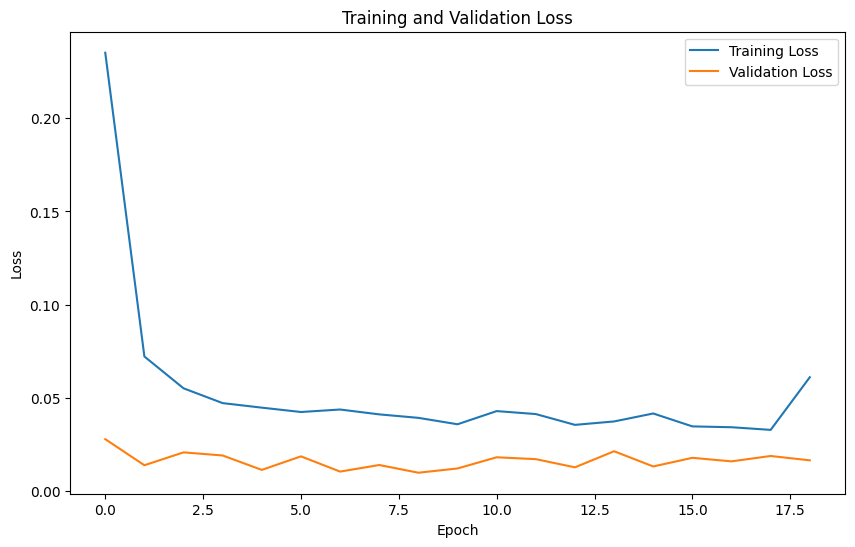

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
RMSE for each predicted day: [np.float64(303.39317889466366), np.float64(320.76799748725), np.float64(375.87597389761225), np.float64(387.2489422718092), np.float64(425.25588402984783)]
MAE for each predicted day: [224.50091137311844, 234.25212440690444, 279.8993322562173, 289.57843305178335, 321.17097129622056]


In [29]:
# Membangun model LSTM
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50),
    Dense(prediction_length)
])

# Loss function 'mean_squared_error' digunakan untuk mengukur perbedaan antara prediksi dan nilai aktual.
model.compile(optimizer='adam', loss='mean_squared_error')

# restore_best_weights=True akan mengembalikan bobot model terbaik.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# min_lr=0.0001 adalah batas learning rate minimum.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# callbacks adalah daftar fungsi yang dijalankan selama pelatihan.
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Memvisualisasikan loss pelatihan dan validasi
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Melakukan prediksi menggunakan data uji
predictions = model.predict(X_test)

# scaler.inverse_transform(predictions) mengembalikan nilai prediksi ke skala harga asli.
predictions = scaler.inverse_transform(predictions)

# scaler.inverse_transform(y_test) mengembalikan nilai aktual ke skala harga asli.
y_test_actual = scaler.inverse_transform(y_test)

# np.sqrt(...) menghitung akar kuadratnya untuk mendapatkan RMSE.
rmse_list = [np.sqrt(mean_squared_error(y_test_actual[:, i], predictions[:, i])) for i in range(prediction_length)]

# mean_absolute_error(y_test_actual[:, i], predictions[:, i]) menghitung MAE untuk hari ke-i.
mae_list = [mean_absolute_error(y_test_actual[:, i], predictions[:, i]) for i in range(prediction_length)]

# Mencetak hasil evaluasi
print(f'RMSE for each predicted day: {rmse_list}')
print(f'MAE for each predicted day: {mae_list}')

Overall RMSE: 365.24692665590237
Overall MAE: 269.8803544768488


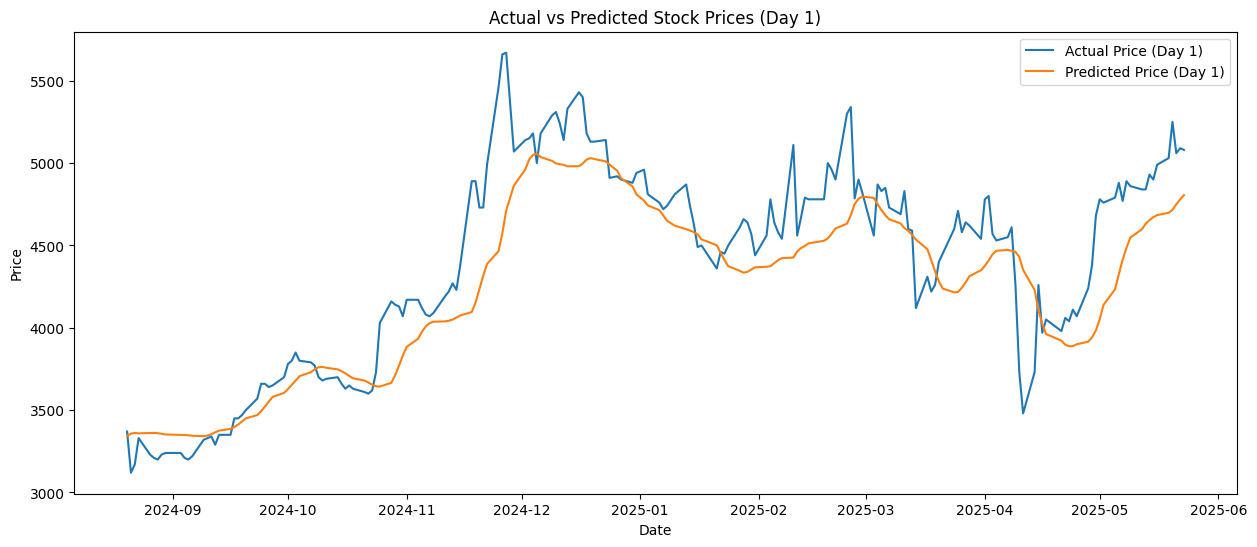

In [30]:
# Calculate overall RMSE and MAE
overall_rmse = np.sqrt(mean_squared_error(y_test_actual.flatten(), predictions.flatten()))
overall_mae = mean_absolute_error(y_test_actual.flatten(), predictions.flatten())

print(f'Overall RMSE: {overall_rmse}')
print(f'Overall MAE: {overall_mae}')

# Plot actual vs predicted prices for the first predicted day
plt.figure(figsize=(15, 6))
start_date_index = len(df_baru) - len(y_test_actual) - sequence_length
prediction_dates = df_baru['Tanggal'].iloc[start_date_index + sequence_length: start_date_index + sequence_length + len(y_test_actual)].reset_index(drop=True)

plt.plot(prediction_dates, y_test_actual[:, 0], label='Actual Price (Day 1)')
plt.plot(prediction_dates, predictions[:, 0], label='Predicted Price (Day 1)')
plt.title('Actual vs Predicted Stock Prices (Day 1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Metrik Evaluasi:
RMSE dan MAE per hari: Dihitung untuk masing-masing hari (hari ke-1 hingga ke-5).
- Overall RMSE: 365.25 → Rata-rata error prediksi keseluruhan sekitar 365 unit.
- Overall MAE: 269.88 → Rata-rata selisih absolut keseluruhan sekitar 269 unit.
- Nilai RMSE dan MAE ini lebih tinggi dibandingkan model sebelumnya (RMSE: 150.18, MAE: 95.20), yang menunjukkan bahwa model ini kurang akurat dalam memprediksi 5 hari ke depan dibandingkan memprediksi hanya 1 hari.

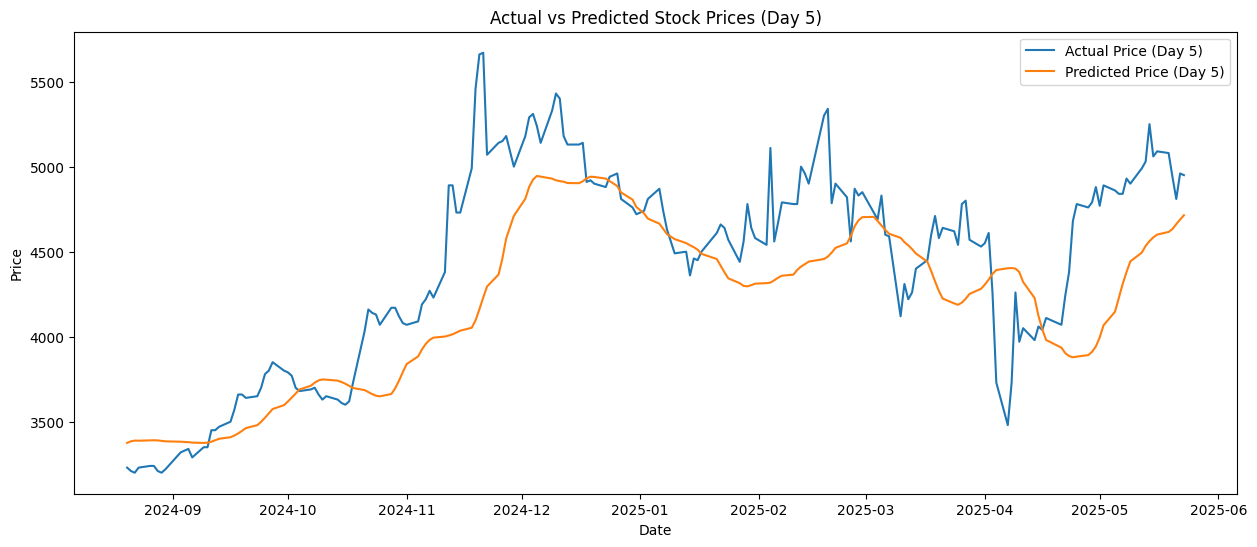

In [31]:
plt.figure(figsize=(15, 6))
plt.plot(prediction_dates, y_test_actual[:, 4], label='Actual Price (Day 5)')
plt.plot(prediction_dates, predictions[:, 4], label='Predicted Price (Day 5)')
plt.title('Actual vs Predicted Stock Prices (Day 5)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

model cukup baik mengikuti tren tetapi terlambat merespons lonjakan tajam, terutama saat harga naik tajam (des 2024) dan drop mendadak (apr 2025).

Kemungkinan penyebab eror
- Kurang banyak fitur: Jika hanya menggunakan harga sebelumnya (lag features), maka model cenderung underfitting terhadap dinamika pasar.
- Model tidak autoregressive: Jika prediksi dilakukan secara langsung untuk 5 hari ke depan, tanpa memperhatikan ketergantungan antar-hari, maka kesalahan akumulatif bisa besar.

Saran Perbaikan
- Tambahkan fitur jangan menggunakan satu fitur saja
- Kombinasikan prediksi dari beberapa model: misalnya kombinasi ARIMA + LSTM atau XGBoost + LSTM.

Kesimpulan Proyek Prediksi Harga Saham GOTO

1. Menjawab Problem Statement
- Prediksi harga saham GOTO untuk beberapa hari ke depan berhasil dilakukan menggunakan data historis harga penutupan.
- Model LSTM terbukti mampu menangkap pola temporal dari data historis, seperti tren naik dan turun harga dalam jangka pendek.
- Namun, performa model masih dapat ditingkatkan, terutama dalam menangkap perubahan harga yang tajam (lonjakan dan penurunan ekstrem), yang terlihat dari peningkatan error saat horizon prediksi lebih jauh.

2. Hasil evaluasi menggunakan metrik:
- RMSE: 365.25
- MAE: 269.88
- Ini menunjukkan bahwa model memiliki kemampuan dasar dalam memprediksi arah harga, namun masih terdapat deviasi yang cukup besar dari nilai aktual, terutama untuk horizon lebih panjang.
- Jika dibandingkan dengan baseline seperti naive forecast (misalnya: harga hari ini = harga kemarin), model LSTM menunjukkan peningkatan akurasi, khususnya dalam mengenali pola jangka pendek.

3. Goals Tercapai
- Model LSTM berhasil dibangun dan diimplementasikan untuk memprediksi harga saham.
- Pola pergerakan harga saham seperti tren dan siklus jangka pendek berhasil ditangkap oleh model.
- Evaluasi dengan metrik RMSE dan MAE memberikan gambaran seberapa baik model bekerja dan menjadi dasar untuk perbaikan selanjutnya (misalnya penambahan fitur, tuning parameter, atau pemilihan arsitektur lanjutan).